In [1]:
import glob
import os
from nilearn.image import (
    binarize_img, concat_imgs, mean_img, 
    threshold_img, math_img, 
    iter_img, index_img
)
from nilearn.plotting import plot_roi, plot_img, plot_stat_map
from nilearn.datasets import load_mni152_template
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiLabelsMasker
from nilearn.regions import connected_regions
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from pathlib import Path

In [2]:
# change if you're not directly on oak and to a figure path that works for you
oak_home = Path('/home/poldrack/oak/data')
outdir = oak_home / 'uh2/aim1_mumford/output'


## Task activation

If you go here: 
/oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output
you'll find all the level 2 analyses for stroop.  The directory names tell the following
stroop_lev1_contrast_LOWER_LEVEL_CONTRAST_rtmod_RT_MODEL_lev2_model_GROUP_MODEL

so the ConsDurNoRT group average output is here:
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_one_sampt

The ConsDurRT group average is here:
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_one_sampt

Both directories have an f-stat (2-sided 1-sample t-test), which I'd combine with the uncorrected t-stats if you need the signs of things.  The directories should have all the info you need, including the randomise call.

The RT correlations models are 
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission
stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission

"new_omission" is what I ran the other day for you to make sure the recent omissions that are clearly bad in some tasks didn't impact the results BUT the paper conjunction has those omitted subjects included still.  I don't think it'll make a difference.  I've completed the MRIQC checks and need to check the fmriprep output files for my questionables from mriqc.  Hopefully I will finish today or tomorrow.  I highly doubt these omissions will have any impact on the conjunction analysis, since that's a 1-sample t-test.  If you think I should redo all of this prior to uploading the preprint and submitting, let me know.

You can peek in the desmat.mat/.con files as a reality check, but the t/fstat1 are for the intercept (ignore) and the t/fstat2 are for the RT difference, which is what you're interested in.  Again, I only ran corrected stats for the 2-sided test (f-test) and perhaps the >0 t-stats are in there too.  So, you'll focus on t/fstat2.




stroop stroop_incong_minus_cong ConsDurNoRT
stroop stroop_incong_minus_cong ConsDurRT
twoByTwo task_switch_cost_100 ConsDurNoRT
twoByTwo task_switch_cost_100 ConsDurRT
twoByTwo cue_switch_cost_100 ConsDurNoRT
twoByTwo cue_switch_cost_100 ConsDurRT
DPX AY-BY ConsDurNoRT
DPX AY-BY ConsDurRT
DPX BX-BY ConsDurNoRT
DPX BX-BY ConsDurRT
discountFix choice ConsDurNoRT
discountFix choice ConsDurRT
ANT congruency_parametric ConsDurNoRT
ANT congruency_parametric ConsDurRT
ANT cue_parametric ConsDurNoRT
ANT cue_parametric ConsDurRT
stopSignal stop_failure-go ConsDurNoRT
stopSignal stop_failure-go ConsDurRT
motorSelectiveStop crit_stop_failure-crit_go ConsDurNoRT
motorSelectiveStop crit_stop_failure-crit_go ConsDurRT


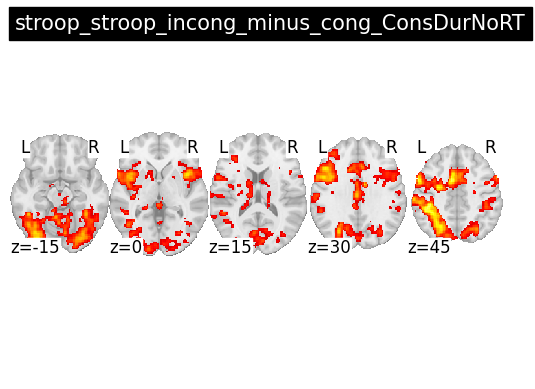

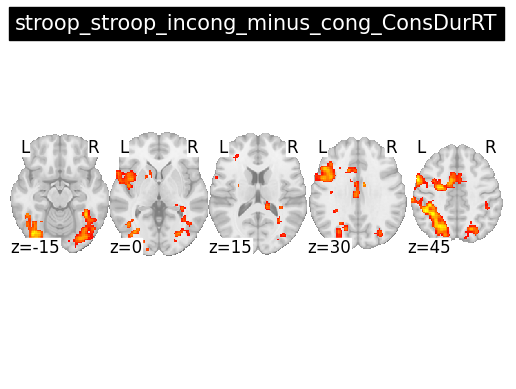

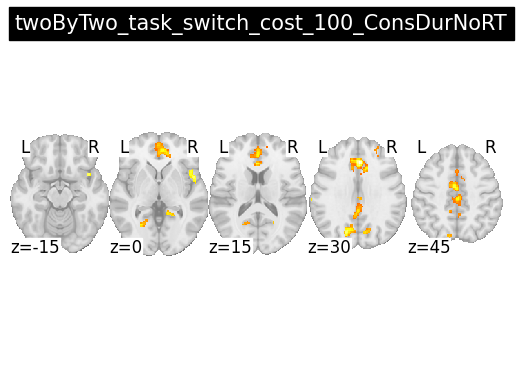

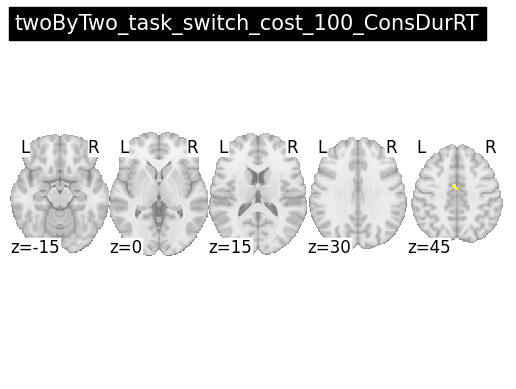

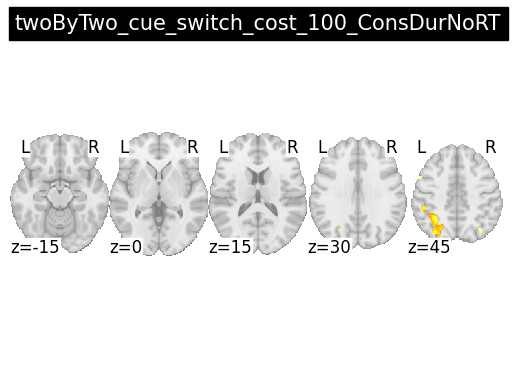

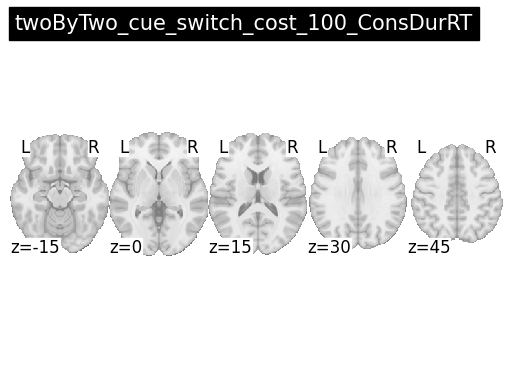

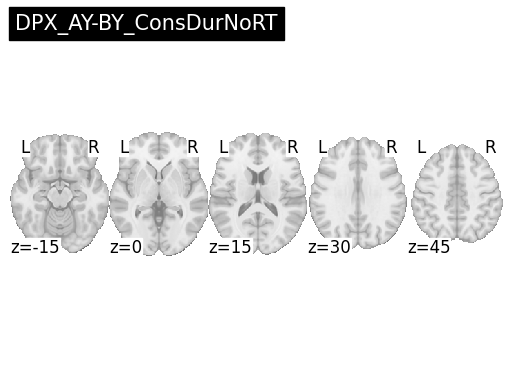

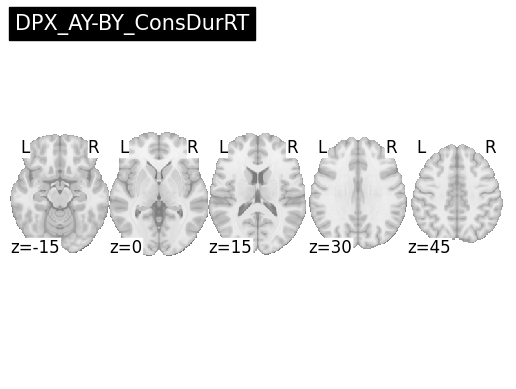

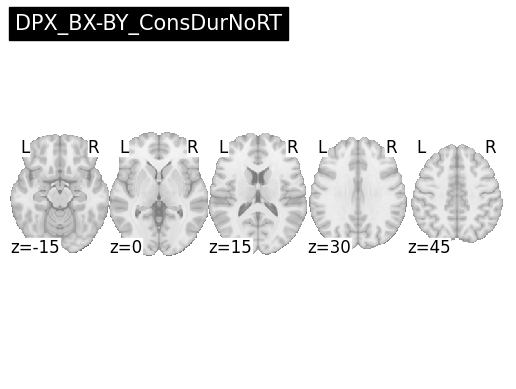

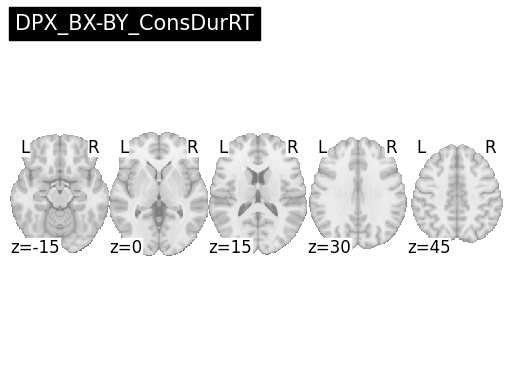

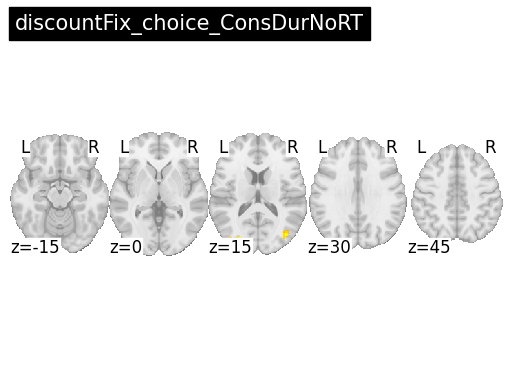

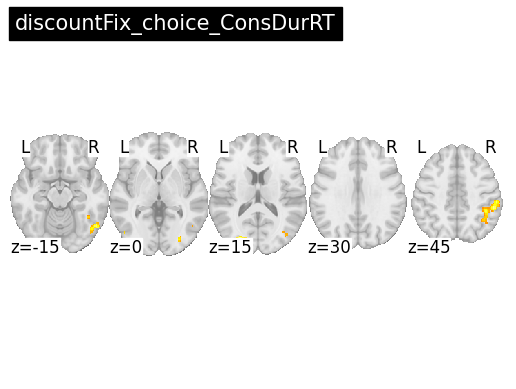

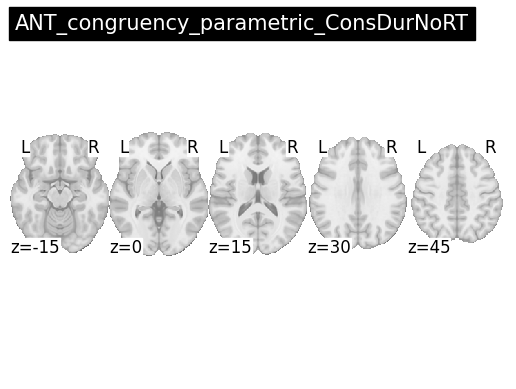

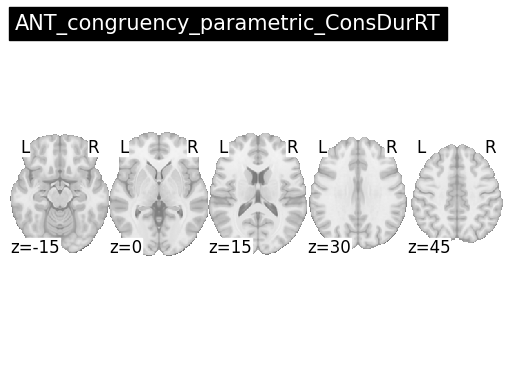

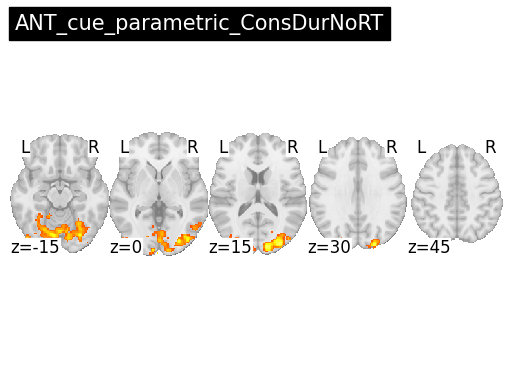

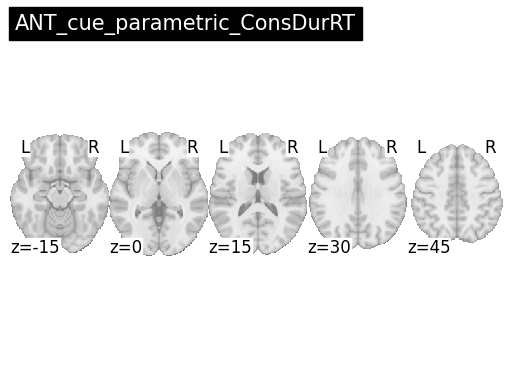

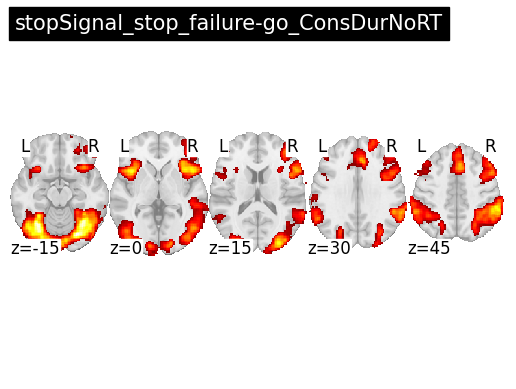

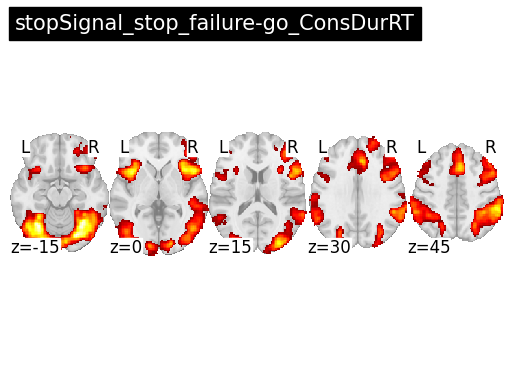

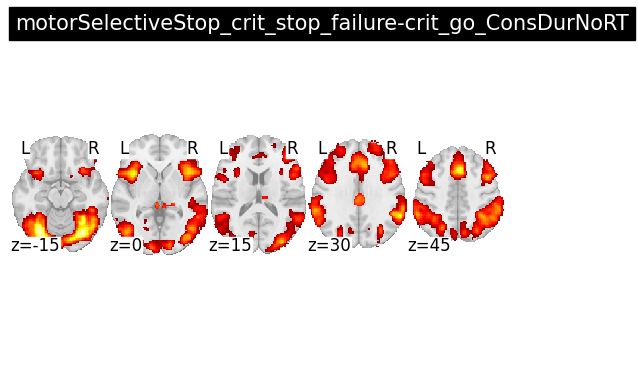

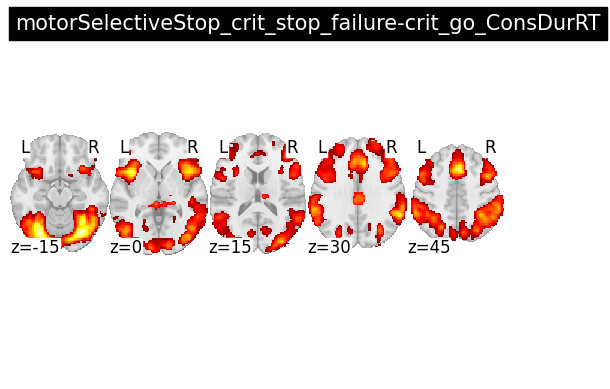

In [8]:
tasks = {
    'stroop': ['stroop_incong_minus_cong'],
    'twoByTwo': ['task_switch_cost_100', 'cue_switch_cost_100'],
    'DPX': ['AY-BY', 'BX-BY'],
    'discountFix': ['choice'],
    'ANT': ['congruency_parametric', 'cue_parametric'],
    'stopSignal': ['stop_failure-go'],
    'motorSelectiveStop': ['crit_stop_failure-crit_go']
}

pthresh = .05
for task, contrasts in tasks.items():
    level2_dir = oak_home / f'uh2/aim1_mumford/output/{task}_lev2_output'
    for contrast in contrasts:
        output_dir = {
            'ConsDurNoRT': level2_dir / f'{task}_lev1_contrast_{contrast}_rtmod_no_rt_lev2_model_one_sampt',
            'ConsDurRT': level2_dir / f'{task}_lev1_contrast_{contrast}_rtmod_rt_uncentered_lev2_model_one_sampt',
        }
        for model, model_outdir in output_dir.items():
            print(task, contrast, model)
            #try:
            if 1:
                fstat = glob.glob(f'{model_outdir}/*corrp_fstat1.nii.gz')
                fstat=fstat[0]
                tstat = [i for i in glob.glob(f'{model_outdir}/*tstat1.nii.gz') if i.find('corrp') < 0]
                tstat=tstat[0]
            #except IndexError:
            #    print('missing stats files, skipping')
            #    continue
            # get the uncorrected t stat
            tstat_img = nib.load(tstat)
            fstat_img = nib.load(fstat)
            # threshold the tstat image using the corrp image
            thresh_img = (fstat_img.get_fdata() > (1 - pthresh)) * tstat_img.get_fdata() * (tstat_img.get_fdata() > 0)
            thresh_tstat =  nib.Nifti1Image(thresh_img, affine=tstat_img.affine, header=tstat_img.header)
            fig, ax = plt.subplots()
            plot_stat_map(thresh_tstat, alpha=1,
                display_mode='z', cut_coords = np.arange(-15, 50, 15), #[-15, 0, 15, 30, 45], 
                annotate=True, axes=ax, colorbar=False, title=f'{task}_{contrast}_{model}',
                         symmetric_cbar=False, threshold=2)

            fig.savefig(f'{task}_{contrast}_{model}.png')


In [4]:
fstats = {}
tstats = {}
thresh_tstats = {}
pthresh = .05

for model, dir in stroop_output_dir.items():
    # use the second contrast for correlation images
    if model.find('_corr') > -1:
        contrast = 2
    else:
        contrast = 1
    fstats[model] = glob.glob(f'{dir}/*corrp_fstat{contrast}.nii.gz')[0]
    # get the uncorrected t stat
    tstats[model] = [i for i in glob.glob(f'{dir}/*tstat{contrast}.nii.gz') if i.find('corrp') < 0][0]
    tstat_img = nib.load(tstats[model])
    fstat_img = nib.load(fstats[model])
    # threshold the tstat image using the corrp image
    thresh_img = (fstat_img.get_fdata() > (1 - pthresh)) * tstat_img.get_fdata()
    thresh_tstats[model] =  nib.Nifti1Image(thresh_img, affine=tstat_img.affine, header=tstat_img.header)

for model in ['ConsDurNoRT', 'ConsDurRT']:
    fig, ax = plt.subplots()
    plot_stat_map(thresh_tstats[model], alpha=1,
        display_mode='z', cut_coords = [-15, 0, 15, 30, 45], 
        annotate=True, axes=ax, colorbar=False)

    fig.savefig(f'stroop_activation_{model}.png')
    

NameError: name 'stroop_output_dir' is not defined

Do the same for other tasks


In [ ]:
t_thresh = 2.5
cluster_thresh = 30

tmap_corr_nort = threshold_img(tstats['ConsDurNoRT_corr'], 
                               threshold=t_thresh, cluster_threshold=cluster_thresh)
fig = plot_rows(tmap_corr_nort, title='ConsDurNoRT_corr')
fig.savefig('tmap_RTcorr_ConsDurNoRT.png')

In [ ]:
plot_stat_map(tmap_corr_nort,
              cut_coords = [30],
              alpha=1,
              display_mode='z',
              annotate=False,
              colorbar=False)
plt.savefig('tmap_corr_noRT_slice.png')

In [ ]:
tmap_corr_rt = threshold_img(tstats['ConsDurRT_corr'], 
                             threshold=t_thresh, cluster_threshold=cluster_thresh)

fig = plot_rows(tmap_corr_rt, title='ConsDurRT_corr')
fig.savefig('tmap_RTcorr_ConsDurRT.png')

In [ ]:
plot_stat_map(tmap_corr_rt,
              cut_coords = [30],
              alpha=1,
              display_mode='z',
              annotate=False,
              colorbar=False)
plt.savefig('tmap_corr_RT_slice.png')

### get plot of RT vs contrast signal across subjects, for the two different models


    The 4D data (contrast estimate across all subjects)
        (no rt)  /oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt.nii.gz
        (yes rt) /oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered.nii.gz
    The design matrix (second column is the RT difference).  SKIP FIRST 5 LINES WHEN READING IN.
        (no rt)  /oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission/desmat.mat
        (yes rt) /oak/stanford/groups/russpold/data/uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission/desmat.mat

In [ ]:
# first do clustering to the cluster from the noRT model (tmap_corr_nort)


regions, _ = connected_regions(tmap_corr_nort)



In [ ]:
# extract mean signal from PFC roi

data_4d = {
    'ConstDurNoRT': oak_home / 'uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt.nii.gz',
    'ConstDurRT': oak_home / 'uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered.nii.gz'
}

In [ ]:
# load design matrices

desmtx = {'NoRT': oak_home / 'uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_no_rt_lev2_model_rt_diff_new_omission/desmat.mat',
          'RT':  oak_home / 'uh2/aim1_mumford/output/stroop_lev2_output/stroop_lev1_contrast_stroop_incong_minus_cong_rtmod_rt_uncentered_lev2_model_rt_diff_new_omission/desmat.mat'}

desmtx_NoRT = np.loadtxt(desmtx['NoRT'], skiprows=5)
desmtx_RT = np.loadtxt(desmtx['RT'], skiprows=5)


In [ ]:
for i, img in enumerate(iter_img(regions)):
    plot_stat_map(img)
    plt.savefig(f'corr_analysis_roi{i}.png')
    # extract signal from roi
    masker = NiftiLabelsMasker(img)
    data_ConstDurNoRT = masker.fit_transform(data_4d['ConstDurNoRT'])
    mean_ConstDurNoRT = data_ConstDurNoRT.mean(axis=1)
    data_ConstDurRT = masker.fit_transform(data_4d['ConstDurRT'])
    mean_ConstDurRT = data_ConstDurRT.mean(axis=1)   
    
    plt.figure(figsize=(6,6))
    plt.scatter(desmtx_NoRT[:, 1], mean_ConstDurNoRT)
    plt.xlabel('RT', fontsize=18)
    plt.ylabel('Activation', fontsize=18)
    plt.title('RT not modeled at first level')
    plt.savefig(f'scatterplot_ConstDurNoRT_roi{i}.png')
    
    plt.figure(figsize=(6,6))
    plt.scatter(desmtx_RT[:, 1], mean_ConstDurRT)
    plt.xlabel('RT', fontsize=18)
    plt.ylabel('Activation', fontsize=18)
    plt.title('RT modeled at first level')
    plt.savefig(f'scatterplot_ConstDurRT_roi{i}.png')
